# Project 1 NYC Subway Network
## Step 1 - Build the Subway Files

This phase of Project 1 constructs the NYC subway graph from the GTFS data files provided by the Metropolitan Transit Authority in the latest available dataset (as of Dec 2021).  The GTFS data files are text files with comma separated fields per row.  However, figuring out the nodes and edges is complicated by  domain specific issues because the purpose of the GTFS data files is not to build graphs but to support scheduling and operations.

## Stops

We begin by defining the nodes which represent subway stations.  This data is stored in the file `stops.txt`.   We load the data and inspect the first 5 rows.

In [2]:
# Import the basic libraries

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_dir = "google_transit/"

stops_file = data_dir + "stops.txt"
stops_df = pd.read_csv(stops_file)
all_stops = stops_df[["stop_id", "stop_name", "stop_lat", "stop_lon", "location_type", "parent_station"]]
all_stops.head()

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station
0,101,Van Cortlandt Park-242 St,40.889248,-73.898583,1,NaN
1,101N,Van Cortlandt Park-242 St,40.889248,-73.898583,0,101
2,101S,Van Cortlandt Park-242 St,40.889248,-73.898583,0,101
3,103,238 St,40.884667,-73.900870,1,NaN
4,103N,238 St,40.884667,-73.900870,0,103


In the above `stops` dataset, each stop is listed 3 times as a `parent` and two `child` stops. 
Using stops `101`, `101N`, `101S` as a related example, we see that the parent stop `101` is identified by the field value `location_type`=`1` while `101N` (the northbound platform of the stop) and `101S` (the southbound platform of the stop) have `location_type` = `0` and use the field `parent_station` as a foreign key back to the `stop_id` of the parent stop `101` through self-join.   However, we'll need to retain the child stops `101N` and `101S` as the edges of our graph are defined in terms of child stops.   For simplicity, we select only essential columns in a dataframe `all_stops`.

## Routes

The `routes.txt` contains the names of the routes.  It is a reference file that defines the lines of services.  For example, A, B, C, 1, 2, 3, 4, 6, 7, etc.   Each route has several useful fields which we load into a dataframe:

*   `route_id` - integer identifier of the line - this is the primary key
*   `route_long_name` - describes the route's name is not unique.  E.g. 5 and 5X are both called Lexington Avenue Express.
*   `route_color` - the hex code color assigned to the line's livery on the map, subway cars and stations.  For example, $\color{#EE352E}{\text{Routes 1, 2, 3 use EE352E}}$.   Route colors are often grouped together.   Route colors may be viewed as edge attributes.


In [4]:
routes_file = data_dir + "routes.txt"
routes_df = pd.read_csv(routes_file)
all_routes = routes_df[["route_id", "route_long_name", "route_color"]]
all_routes.head()

,route_id,route_long_name,route_color
0,1,Broadway - 7 Avenue Local,EE352E
1,2,7 Avenue Express,EE352E
2,3,7 Avenue Express,EE352E
3,4,Lexington Avenue Express,00933C
4,5,Lexington Avenue Express,00933C


# Calendar

We load the list of available services.   A service associates a schedule of availability of multiple subway lines by day of week and holidays.   We are only going to use weekday services as an object to filter the set of trips as there are thousands of trips for each line with repetitive description of edges.

In [5]:
calendar_file = data_dir + "calendar.txt"
calendar_df = pd.read_csv(calendar_file)
all_calendar = calendar_df[["service_id", "start_date", "end_date"]]
all_calendar[ all_calendar["service_id"].str.contains("Weekday") ].head()

,service_id,start_date,end_date
23,AFA21GEN-1091-Weekday-00,20211220,20220624
24,AFA21GEN-2097-Weekday-00,20211220,20220624
25,AFA21GEN-3087-Weekday-00,20211220,20220624
26,AFA21GEN-4099-Weekday-00,20211220,20220624
27,AFA21GEN-5108-Weekday-00,20211220,20220624


# Trips

The `trips.txt` file joins three object types:  routes, services and trips.   Trips are the instances of services associated with a route containing a direction of travel (outbound or inbound).   The direction of travel is immaterial to our graph and we treat both directions as equivalent.   

*   `route_id` is a foreign key to the same column in `routes.txt`
*   `service_id` is a foreign key to the same column in `calendar.txt`

The `trip_id` is unique to the file and is in a one-to-many relationship with the `route_id` and `service_id` as it specifies the time of day when the trip is scheduled to begin its operation and the direction.

In [6]:
trips_file = data_dir + "trips.txt"
trips_df = pd.read_csv(trips_file)
all_trips = trips_df[["route_id", "service_id", "trip_id", "direction_id"]]

all_trips[ all_trips["service_id"].str.contains("Weekday") ].head()

,route_id,service_id,trip_id,direction_id
584,1,AFA21GEN-1091-Weekday-00,AFA21GEN-1091-Weekday-00_000650_1..S03R,1
585,1,AFA21GEN-1091-Weekday-00,AFA21GEN-1091-Weekday-00_002550_1..S03R,1
586,1,AFA21GEN-1091-Weekday-00,AFA21GEN-1091-Weekday-00_004550_1..S03R,1
587,1,AFA21GEN-1091-Weekday-00,AFA21GEN-1091-Weekday-00_006550_1..S03R,1
588,1,AFA21GEN-1091-Weekday-00,AFA21GEN-1091-Weekday-00_007450_1..N03R,0


# Stop Times

The file `stop_times.txt` contains the list of stops along with a sequence number of each trip listed in the trips file.
The essential information of each trip is the scheduled ordered sequence of stops.  Consecutive stops within an ordered sequence of the trip define the directed edges of a digraph.  Since we are interested in the undirected network, we will ignore the directionality of the edges when scanning the trips file.

In [7]:
stop_times_file = data_dir + "stop_times.txt"
stop_times_df = pd.read_csv(stop_times_file)
all_stop_times = stop_times_df[["trip_id", "stop_id", "stop_sequence" ]]

all_stop_times[ all_stop_times["trip_id"].str.contains("Weekday") ].head( )

,trip_id,stop_id,stop_sequence
22192,AFA21GEN-1091-Weekday-00_000650_1..S03R,101S,1
22193,AFA21GEN-1091-Weekday-00_000650_1..S03R,103S,2
22194,AFA21GEN-1091-Weekday-00_000650_1..S03R,104S,3
22195,AFA21GEN-1091-Weekday-00_000650_1..S03R,106S,4
22196,AFA21GEN-1091-Weekday-00_000650_1..S03R,107S,5


A unique key of  the `all_stop_times` dataframe are the two columns `trip_id`, `stop_sequence`.  We exploit this fact to build the edge list below.

## Step 2.  Constructing the Subway Network Graphs

To construct the network, we need to form equivalence classes of several GTFS object types.
We choose only one representative of multiple members of an equivalence class of object types with 2 strategies.

*   For nodes, we'll use only the parent node in our network.  

*   The edge information has even more members in the equivalence class.   For each two adjacent stops (nodes) in our graph,  multiple routes, multiple services and multiple trips may all include the two stops.   In other words, each directed edge could be listed dozens of times within the `all_stop_times` dataframe.
     +  In any edge, the order of nodes must be lexicographically increasing.   We will represent each edge as an ordered pair of parent stops.  For example, stops `101S` and `103S` are consecutive stops for trip `AFA21GEN-1091-Weekday-00_000650_1..S03R`.   
The corresponding edge is the pair `(101, 103)`.
     +  We will maintain a dictionary of the edges.   If an edge has already been created while parsing `all_stop_times`, we don't create a duplicate edge.



In [8]:
len(all_stops[all_stops["location_type"] == 1 ].stop_id.unique())

499

To construct the edge list, we first join the parent `stop_id` to each row of the stop times dataframe.
Next, we assign the previous sequence number to each stop along a trip.  This value is saved in a column called `prior_stop_sequence`.  The original `stop_sequence` always begins at 1, so the `prior_stop_sequence` = 0 for the initial stop of the trip.
Lastly, we make a deep copy of the joined data frame in order to get the parent station of the current stop and the prior stop in the same row. 

In [9]:
res_stop_times = pd.merge( all_stop_times, all_stops , on = ['stop_id'] )

In [10]:
res_stops_times_trips = pd.merge( res_stop_times, all_trips, on = ['trip_id' ] )
res_x = res_stops_times_trips[["route_id", "trip_id", "stop_sequence", "parent_station"]]
res_prior_x = res_x.copy()

res_x['prior_stop_sequence'] = res_x['stop_sequence'] - 1
res_x

,route_id,trip_id,stop_sequence,parent_station,prior_stop_sequence
0,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,1,101,0
1,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,2,103,1
2,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,3,104,2
3,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,4,106,3
4,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,5,107,4
...,...,...,...,...,...
542113,SI,SIR-FA2017-SI017-Weekday-08_045600_SI..N02R,9,S27,8
542114,SI,SIR-FA2017-SI017-Weekday-08_045600_SI..N02R,10,S28,9
542115,SI,SIR-FA2017-SI017-Weekday-08_045600_SI..N02R,11,S29,10
542116,SI,SIR-FA2017-SI017-Weekday-08_045600_SI..N02R,12,S30,11


It is easier to rename some columns of the dataframe representing the prior stop of each trip before doing the join rather than accept the default column renaming by pandas.

In [11]:
res_prior_x.rename(columns = {'parent_station' : 'prior_station' , 
                              'stop_sequence' : 'prior_stop_sequence' ,
                              'route_id' : 'prior_route_id'
                             }, inplace = True)
res_prior_x = res_prior_x[['trip_id', 'prior_stop_sequence', 'prior_station']]

In [12]:
res_edges = pd.merge(res_x, res_prior_x, on = ['trip_id', 'prior_stop_sequence'] )
res_edges.head()

,route_id,trip_id,stop_sequence,parent_station,prior_stop_sequence,prior_station
0,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,2,103,1,101
1,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,3,104,2,103
2,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,4,106,3,104
3,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,5,107,4,106
4,1,AFA21GEN-1037-Sunday-00_000600_1..S03R,6,108,5,107


The dataframe `res_edges` contains multiple instances of directed edges.  The multiplicity arises from the multiple trips for the same same-pair.  Moreover, we are interested in undirected edges, so we use lexicographic sort on the parent station names to ensure each edge only appears once.

In the code below, we construct derived columns `parent_a` and `parent_b` to always means either the parent station or the prior station in which `parent_a` is always lexicographically before `parent_b`.  This ensures that all edges are represented in the unlikely chance that some trips go from station X to station Y but not vice versa.  The unique set of pairs of (`parent_a`, `parent_b`) stop_ids represent all undirected edges in the NYC Subway network.

In [13]:
sel_res_edges = res_edges[["parent_station", "prior_station", "route_id"]].copy()

sel_res_edges['parent_a'] = np.where( sel_res_edges['parent_station'] < sel_res_edges['prior_station'], 
                                         sel_res_edges['parent_station'] ,
                                         sel_res_edges['prior_station'] )

sel_res_edges['parent_b'] = np.where( sel_res_edges['parent_station'] > sel_res_edges['prior_station'], 
                                         sel_res_edges['parent_station'] ,
                                         sel_res_edges['prior_station'] )

no_dups_res_edges = sel_res_edges[['parent_a', 'parent_b']].drop_duplicates(keep = 'last')

Besides undirected edges, we may need to know the name of the route joining each edge.  When a pair of nodes have multiple routes connecting them, the same unidirected edge appears multiple times.  This is stored in the dataframe `no_dups_route_edges`.   The route_id becomes an edge attribute, and the resulting graph becomes a multigraph.

In [14]:
no_dups_route_edges = sel_res_edges[['parent_a', 'parent_b', 'route_id']].drop_duplicates(keep = 'last')
no_dups_route_edges

,parent_a,parent_b,route_id
69693,139,142,1
69694,138,139,1
69695,137,138,1
69696,136,137,1
69697,135,136,1
...,...,...,...
522459,S26,S27,SI
522460,S27,S28,SI
522461,S28,S29,SI
522462,S29,S30,SI


In [15]:
sel_res_edges

,parent_station,prior_station,route_id,parent_a,parent_b
0,103,101,1,101,103
1,104,103,1,103,104
2,106,104,1,104,106
3,107,106,1,106,107
4,108,107,1,107,108
...,...,...,...,...,...
522459,S27,S26,SI,S26,S27
522460,S28,S27,SI,S27,S28
522461,S29,S28,SI,S28,S29
522462,S30,S29,SI,S29,S30


In [16]:
no_dups_res_edges.head()

,parent_a,parent_b
69693,139,142
69694,138,139
69695,137,138
69713,119,120
69714,118,119


The above procedure shows over 522 thousand rows which collapse to a set of 573 edges.  

In [17]:
len(sel_res_edges), len(no_dups_res_edges)

(522464, 573)

There are 496 NYC subway stops extracted from the above list of edges.  These stops are collected in the dataframe `nodes_used` below.

In [18]:
nodes_used_ids =  pd.DataFrame( np.unique( no_dups_res_edges[['parent_a', 'parent_b']].values ) , columns = ["stop_id" ])

In [19]:
len(nodes_used_ids)

496

In [20]:
check_unused_nodes = pd.merge(all_stops, nodes_used_ids, on = ['stop_id'] , how = 'left', indicator = True )

In [21]:
check_unused_nodes[ (check_unused_nodes['location_type'] == 1) & 
                   ( check_unused_nodes['_merge'] == 'left_only' )]

,stop_id,stop_name,stop_lat,stop_lon,location_type,parent_station,_merge
111,140,South Ferry Loop,40.701411,-74.013205,1,NaN,left_only
1086,H19,Broad Channel,40.609014,-73.816024,1,NaN,left_only
1293,N12,S.B. Coney Island,40.577422,-73.981233,1,NaN,left_only


3 station stops are omitted from the network but included in the raw GTFS files.  They appear to have no service documented in the `stop_times.txt`.   They are outliers and pose no issues for the following reasons:

*  Stop 140 `South Ferry Loop` is defunct since 2017 and transferable from `Whitehall Street - South Ferry` R27.
*  Stop H19 Broad Channel on the A line is located on a small island in Jamaica Bay and is the 2nd least used station in the subway system.
*  Stop N12 refers to Coney Island-Stillwell Avenue Station which is a major terminus.  However, that stop coincides with the D train station D43 which is active.

Now we supplement `nodes_used` with longitude, latitude and other categorical metadata.

In [22]:
nodes_used = pd.merge(nodes_used_ids, 
                      all_stops, on = ['stop_id'], how = 'inner' )[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']]
nodes_used

,stop_id,stop_name,stop_lat,stop_lon
0,101,Van Cortlandt Park-242 St,40.889248,-73.898583
1,103,238 St,40.884667,-73.900870
2,104,231 St,40.878856,-73.904834
3,106,Marble Hill-225 St,40.874561,-73.909831
4,107,215 St,40.869444,-73.915279
...,...,...,...,...
491,S27,Grasmere,40.603117,-74.084087
492,S28,Clifton,40.621319,-74.071402
493,S29,Stapleton,40.627915,-74.075162
494,S30,Tompkinsville,40.636949,-74.074835


## Step 3.  Building the Network

Several graphs are needed to complete the analyses.

*  A graph $G1$ using the undirected and unlabeled edges.  Nodes are labeled with longitude, latitude and station name.

*  A multi-graph $G2$ using the undirected edges and labeled edges.  Nodes are labeled with longitude, latitude and station name.

*  A graph $G3$ will link stations where transfers are allowed.   Here some nodes can have borough, multiple station names, longitudes and latitudes.  Edges remain undirected and unlabeled.  

In [23]:
G1 = nx.Graph()


for r, d in nodes_used.iterrows():
    G1.add_node(d["stop_id"], stop_name = d["stop_name"] , lat = d["stop_lat"] , lon = d["stop_lon"])

    
for r, d in no_dups_res_edges.iterrows():
    G1.add_edge(d['parent_a'], d['parent_b'])

In [24]:

pos = {}

for r, d in nodes_used.iterrows():
    lon = float(d["stop_lon"] )
    lat = float(d["stop_lat"] )
    node = d["stop_id"]
    pos.update( { node : ( lon, lat)   } )

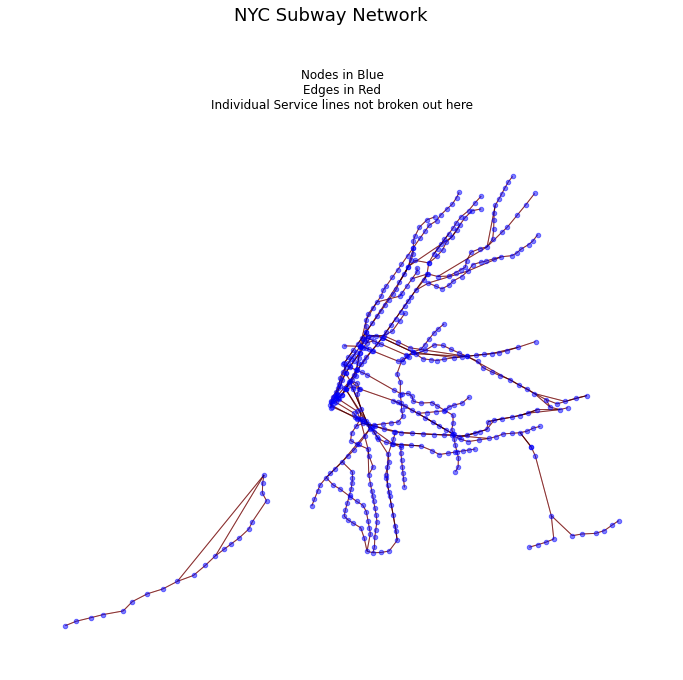

In [25]:
plt.figure(figsize = (12, 10))
plt.tight_layout()
plt.axis("off")

plt.suptitle("NYC Subway Network", y = 1.05 ,fontsize= 18)

plt.title("""Nodes in Blue
Edges in Red
Individual Service lines not broken out here
""", fontsize=12)



nx.draw_networkx_edges(G1, pos = pos, 
                       width = 1, 
                       edge_color = 'red', 
                       alpha = 0.6 )

nx.draw(G1, pos = pos ,   
        with_labels = False ,
        alpha = 0.5 ,
        node_size = 20, 
        node_color = 'blue' )


In [26]:
nx.write_graphml(G1, "Subway_G1.graphml")

Let's verify G1 is valid when restored from file.

In [28]:
G1_test = nx.read_graphml("Subway_G1.graphml")

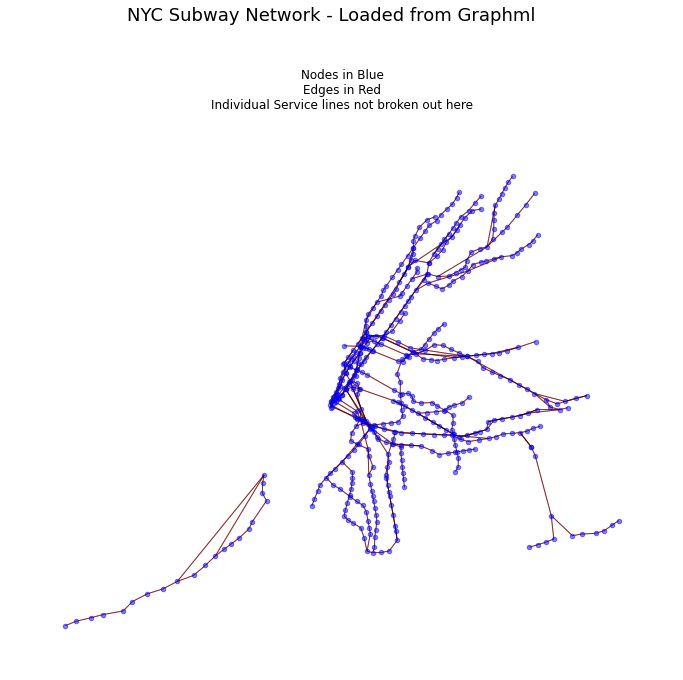

In [30]:
plt.figure(figsize = (12, 10))
plt.tight_layout()
plt.axis("off")

plt.suptitle("NYC Subway Network - Loaded from Graphml", y = 1.05 ,fontsize= 18)

plt.title("""Nodes in Blue
Edges in Red
Individual Service lines not broken out here
""", fontsize=12)



nx.draw_networkx_edges(G1_test, pos = pos, 
                       width = 1, 
                       edge_color = 'red', 
                       alpha = 0.6 )

nx.draw(G1_test, pos = pos ,   
        with_labels = False ,
        alpha = 0.5 ,
        node_size = 20, 
        node_color = 'blue' )

If the above graph looks like the NYC subway, the graph was correctly saved to graphml file.

### Adding a Multigraph with Routes

We save a multigraph $G2$ in which the edges are assigned route attributes.

In [32]:
G2 = nx.MultiGraph()


for r, d in nodes_used.iterrows():
    G2.add_node(d["stop_id"], stop_name = d["stop_name"] , lat = d["stop_lat"] , lon = d["stop_lon"])

    
for r, d in no_dups_route_edges.iterrows():
    G2.add_edge(d['parent_a'], d['parent_b'], route_id = d['route_id'])

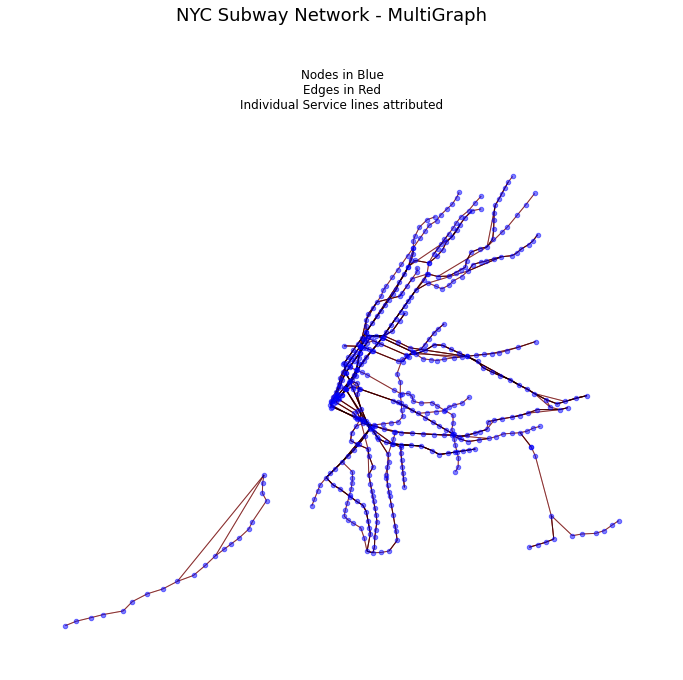

In [34]:
plt.figure(figsize = (12, 10))
plt.tight_layout()
plt.axis("off")

plt.suptitle("NYC Subway Network - MultiGraph", y = 1.05 ,fontsize= 18)

plt.title("""Nodes in Blue
Edges in Red
Individual Service lines attributed
""", fontsize=12)



nx.draw_networkx_edges(G2, pos = pos, 
                       width = 1, 
                       edge_color = 'red', 
                       alpha = 0.6 )

nx.draw(G2, pos = pos ,   
        with_labels = False ,
        alpha = 0.5 ,
        node_size = 20, 
        node_color = 'blue' )

In [35]:
nx.write_graphml(G2, "Subway_G2.graphml")